In [2]:
import pandas as pd
import xgboost as xgb
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import os

pd.options.display.max_columns = None


In [3]:
# Read in processed training data
s3_path = 's3://colby-wight/Model_13_train.csv'
df_train = pd.read_csv(s3_path)

# Remove columns that aren't features
df_train = df_train.drop(['y_30_dpd_120', 'contract_date', 'application_id', 'y_pred', 'corelIdScore_999_flag', 'vendor_classification_new'], axis=1)

In [4]:
# Read in deployment data

conn = snowflake.connector.connect(
                account = 'byb44065.us-east-1',
                user = os.getenv('SNOWFLAKE_USERNAME'),
                password = os.getenv('SNOWFLAKE_PASSWORD'),
                database = 'BRZ_CLKDATA_LEGACY',
                schema = 'DBO',
                warehouse = 'WH_DATA_SCIENTISTS'
            )

query = """
SELECT 
    tpp_log.id,
    tpp_log.application_id,
    tpp_log.created_ts,
    application.status,
    application.MR_DATAROBOT_MODEL_ID,
    -- shared features 
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_installmentBalance) AS experian_experianProfileSummary_installmentBalance,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalRevolvingBalance) AS experian_experianProfileSummary_totalRevolvingBalance,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalRevolvingAvailablePercent) AS experian_experianProfileSummary_totalRevolvingAvailablePercent,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_pastDueAmount) AS experian_experianProfileSummary_pastDueAmount,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_monthlyPayment) AS experian_experianProfileSummary_monthlyPayment,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter) AS experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalInquiriesCounter) AS experian_experianProfileSummary_totalInquiriesCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalTradeItemsCounter) AS experian_experianProfileSummary_totalTradeItemsCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_paidAccountsCounter) AS experian_experianProfileSummary_paidAccountsCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_wasDelinquentDerogCounter) AS experian_experianProfileSummary_wasDelinquentDerogCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_thirtyDayCounter) AS experian_experianProfileSummary_thirtyDayCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_ninetyPlusDayCounter) AS experian_experianProfileSummary_ninetyPlusDayCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_derogCounter) AS experian_experianProfileSummary_derogCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianRiskModel_V3) AS experian_experianRiskModel_V3,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianRiskModel_RC) AS experian_experianRiskModel_RC,
    TO_DOUBLE(PARSE_JSON(tpp_content):datax_dataxReport_idaScore) AS datax_dataxReport_idaScore,
    TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicInquiryReport_corelIdScore) AS coreLogic_coreLogicInquiryReport_corelIdScore,
    TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicApplicantVariable_TTInqall00) AS coreLogic_coreLogicApplicantVariable_TTInqall00,
    TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicApplicantVariable_TTRecinqm) AS coreLogic_coreLogicApplicantVariable_TTRecinqm,
    PARSE_JSON(tpp_content):vendor_equipment_type::STRING AS vendor_equipment_type
FROM application 
left join tpp_log on application.id = tpp_log.application_id
WHERE tpp_type_id = 5 
  AND response = FALSE
  AND COALESCE(
        TO_DOUBLE(PARSE_JSON(tpp_content):datax_dataxReport_idaScore),
        TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicInquiryReport_corelIdScore),
        TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicApplicantVariable_TTRecinqm)
    ) IS NOT NULL
  -- AND application_id = 757694
  AND tpp_log.created_ts >= '2024-12-04 00:00:00.000'
  -- AND tpp_log.created_ts >= '2024-12-11 00:00:00.000'
  -- ANd tpp_log.created_ts <= '2024-12-09 18:06:02.051239' -- to keep the dataset constant during developement
  ORDER by APPLICATION_ID"""

df = pd.read_sql(query, conn)
# conn.close()

# Filter for funded apps
# df = df[(df['STATUS']=='FUNDED') & (df['MR_DATAROBOT_MODEL_ID'] == 13)]

# Remove where TTINqall_00 is 0 since this will be for model 11 and not model 13. 
df = df[df['CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00']!=0]
# Remove duplicates. Since model 11 and 13 get the same features. 
cols = ['APPLICATION_ID', 'EXPERIAN_EXPERIANPROFILESUMMARY_INSTALLMENTBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PASTDUEAMOUNT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_MONTHLYPAYMENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGAVAILABLEPERCENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALINQUIRIESCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_INQUIRIESDURINGLASTSIXMONTHSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALTRADEITEMSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PAIDACCOUNTSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_WASDELINQUENTDEROGCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_THIRTYDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_NINETYPLUSDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_DEROGCOUNTER',
       'EXPERIAN_EXPERIANRISKMODEL_RC', 'EXPERIAN_EXPERIANRISKMODEL_V3',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00',
       'DATAX_DATAXREPORT_IDASCORE',
       'CORELOGIC_CORELOGICINQUIRYREPORT_CORELIDSCORE',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTRECINQM',
       'VENDOR_EQUIPMENT_TYPE']

df = df[~df[cols].duplicated()]

print(df.shape)
print(df['APPLICATION_ID'].nunique())
df.head()

# align feature names 
train_names = ['experian_experianProfileSummary_installmentBalance',
       'experian_experianProfileSummary_totalRevolvingBalance',
       'experian_experianProfileSummary_totalRevolvingAvailablePercent',
       'experian_experianProfileSummary_pastDueAmount',
       'experian_experianProfileSummary_monthlyPayment',
       'experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter',
       'experian_experianProfileSummary_totalInquiriesCounter',
       'experian_experianProfileSummary_totalTradeItemsCounter',
       'experian_experianProfileSummary_paidAccountsCounter',
       'experian_experianProfileSummary_wasDelinquentDerogCounter',
       'experian_experianProfileSummary_thirtyDayCounter',
       'experian_experianProfileSummary_ninetyPlusDayCounter',
       'experian_experianProfileSummary_derogCounter',
       'experian_experianRiskModel_V3', 
       'experian_experianRiskModel_RC',
       'datax_dataxReport_idaScore',
       'coreLogic_coreLogicInquiryReport_corelIdScore',
       'coreLogic_coreLogicApplicantVariable_TTInqall00',
       'coreLogic_coreLogicApplicantVariable_TTRecinqm', 
       'vendor_equipment_type']

prod_names = ['EXPERIAN_EXPERIANPROFILESUMMARY_INSTALLMENTBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGAVAILABLEPERCENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PASTDUEAMOUNT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_MONTHLYPAYMENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_INQUIRIESDURINGLASTSIXMONTHSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALINQUIRIESCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALTRADEITEMSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PAIDACCOUNTSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_WASDELINQUENTDEROGCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_THIRTYDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_NINETYPLUSDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_DEROGCOUNTER',
       'EXPERIAN_EXPERIANRISKMODEL_V3', 'EXPERIAN_EXPERIANRISKMODEL_RC',
       'DATAX_DATAXREPORT_IDASCORE',
       'CORELOGIC_CORELOGICINQUIRYREPORT_CORELIDSCORE',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTRECINQM',
       'VENDOR_EQUIPMENT_TYPE']

dict(zip(train_names,prod_names))

df = df.rename(dict(zip(prod_names, train_names)), axis=1)

/tmp/ipykernel_3480013/971938576.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


(14758, 25)
14664


In [5]:
# At this point we need to append model 8 and model 11 scores 
query = """with m13_pre as ( select *, row_number() over(partition by application_id order by probability asc) as rn
from score_report_by_owner
where model_id = 13),
m8_pre as( select *, row_number() over(partition by application_id order by probability asc) as rn
from score_report_by_owner
where model_id = 8),

joined as (select m13_pre.application_id, m13_pre.probability as m13_score, m8_pre.probability as m8_score
from m13_pre 
left join m8_pre on m13_pre.application_id= m8_pre.application_id
where m13_pre.rn = 1
and m8_pre.rn=1
and m13_pre.application_id >= 754132)

-- select count(*), count(application_id), count(distinct application_id), count(m13_score), count(m8_score)
select *
from joined"""

df_scores = pd.read_sql(query, conn)


conn.close()

print(df.shape)
df = df.merge(df_scores, how="left", on="APPLICATION_ID")
print(df.shape)


def assign_m13_grade(probability):
    if probability <= 0.014:
        return 'A'
    elif 0.014 < probability <= 0.0225:
        return 'B'
    elif 0.0225 < probability <= 0.045:
        return 'C'
    elif 0.045 < probability <= 0.088:
        return 'D'
    elif 0.088 < probability <= 0.12:
        return 'E'
    elif 0.12 < probability <= 0.15:
        return 'F'
    elif 0.15 < probability <= 0.21:
        return 'G'
    else:
        return 'X' # for declines
# Apply the function to create the m13_grade column
df['m13_grade'] = df['M13_SCORE'].apply(assign_m13_grade)

# Grade thresholds for Model 8.
def assign_m8_grade(probability):
    """
    Assigns a grade (A-G) based on the probability score using Model 8 thresholds.
    """
    if 0 <= probability < 0.0155:
        return 'A'
    elif 0.0155 <= probability < 0.032:
        return 'B'
    elif 0.032 <= probability < 0.0691:
        return 'C'
    elif 0.0691 <= probability < 0.1535:
        return 'D'
    elif 0.1535 <= probability < 0.2138:
        return 'E'
    elif 0.2138 <= probability < 0.28575:
        return 'F'
    elif 0.28575 <= probability < 0.415:
        return 'G'
    else:
        return 'X'  # For probabilities outside the defined ranges
    
    # Apply the function to create the m8_grade column
df['m8_grade'] = df['M8_SCORE'].apply(assign_m8_grade)

# df['APPLICATION_ID'].min()

/tmp/ipykernel_3480013/1796643826.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_scores = pd.read_sql(query, conn)


(14758, 25)
(14758, 27)


In [6]:
# print(df.shape)
# print(len(df[df['m8_grade']=='A']))
# print(len(df[df['m13_grade']=='A']))

# print("dark score period As in m8 and m13")
# print(len(df[(df['m8_grade']=='A') & (df['CREATED_TS']<='2024-12-10')]))
# print(len(df[(df['m13_grade']=='A') & (df['CREATED_TS']<='2024-12-10')]))

# print("production period As in m8 and m13")
# print(len(df[(df['m8_grade']=='A') & (df['CREATED_TS']>'2024-12-10')]))
# print(len(df[(df['m13_grade']=='A') & (df['CREATED_TS']>'2024-12-10')]))
# # print(len(df[df['m13_grade']=='A']))



In [7]:
# Dark score period
condition = (df['CREATED_TS']<='2024-12-10')

pd.crosstab(df[condition]['m8_grade'], df[condition]['m13_grade'], margins=True, margins_name='Total')

m13_grade,A,B,C,D,E,F,G,X,Total
m8_grade,,,,,,,,,
A,17,23,10,4,1,0,0,0,55
B,17,44,52,23,6,1,1,0,144
C,14,42,119,114,38,9,6,1,343
D,4,20,113,198,56,42,44,18,495
E,0,2,23,65,39,34,43,17,223
F,0,1,24,43,32,33,36,29,198
G,0,1,10,45,42,52,64,74,288
X,0,0,4,14,13,28,83,201,343
Total,52,133,355,506,227,199,277,340,2089


In [8]:
# production
condition = (df['CREATED_TS']>'2024-12-10')

pd.crosstab(df[condition]['m8_grade'], df[condition]['m13_grade'], margins=True, margins_name='Total')

m13_grade,A,B,C,D,E,F,G,X,Total
m8_grade,,,,,,,,,
A,99,164,114,23,2,0,0,0,402
B,76,265,395,160,21,3,1,0,921
C,51,273,786,664,182,79,50,7,2092
D,14,122,729,1021,509,301,255,71,3022
E,4,14,187,401,229,216,274,109,1434
F,0,9,80,251,208,162,244,214,1168
G,0,1,42,237,225,252,430,454,1641
X,0,0,7,74,127,192,409,1180,1989
Total,244,848,2340,2831,1503,1205,1663,2035,12669


In [9]:
model_features = ['experian_experianProfileSummary_installmentBalance',
       'experian_experianProfileSummary_totalRevolvingBalance',
       'experian_experianProfileSummary_totalRevolvingAvailablePercent',
       'experian_experianProfileSummary_pastDueAmount',
       'experian_experianProfileSummary_monthlyPayment',
       'experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter',
       'experian_experianProfileSummary_totalInquiriesCounter',
       'experian_experianProfileSummary_totalTradeItemsCounter',
       'experian_experianProfileSummary_paidAccountsCounter',
       'experian_experianProfileSummary_wasDelinquentDerogCounter',
       'experian_experianProfileSummary_thirtyDayCounter',
       'experian_experianProfileSummary_ninetyPlusDayCounter',
       'experian_experianProfileSummary_derogCounter',
       'experian_experianRiskModel_V3', 'experian_experianRiskModel_RC',
       'datax_dataxReport_idaScore',
       'coreLogic_coreLogicInquiryReport_corelIdScore',
       'coreLogic_coreLogicApplicantVariable_TTInqall00',
       'coreLogic_coreLogicApplicantVariable_TTRecinqm',
       'vendor_equipment_type']

In [10]:
# Process production data 

df.loc[df['coreLogic_coreLogicInquiryReport_corelIdScore'] == 999, 'coreLogic_coreLogicInquiryReport_corelIdScore'] = -99
df['rc_9105_flag'] = df['experian_experianRiskModel_RC'].apply(lambda x: 1 if x == 9105 else 0)
df.loc[df['experian_experianRiskModel_RC'] == 9105, 'experian_experianRiskModel_RC'] = -99

cond = (df['experian_experianRiskModel_V3'] != -99) & (~df['experian_experianRiskModel_V3'].between(300, 850))
df.loc[cond, 'experian_experianRiskModel_V3'] = 500

equipment_types = ['Trailers', 'Industrial', 'Food Service', 'Construction/Landscaping', 'Automotive', 'Janitorial/Remediation','Food Truck', 'DTG/Embroidery', 'Entertainment/Amusement', 'Photo-A/V', 'Rental', 'Office/Printing']  
def set_equipment_group_new(vendor_class):
    if vendor_class in equipment_types:
        return vendor_class
    else:
        return 'Other'
      
df['vendor_classification_new'] = df['vendor_equipment_type'].apply(set_equipment_group_new).astype('category')
df = df.drop(['vendor_equipment_type'], axis=1)

dummy_columns = ["equipment_type_Automotive",
                    "equipment_type_Construction/Landscaping",
                    "equipment_type_DTG/Embroidery",
                    "equipment_type_Entertainment/Amusement",
                    "equipment_type_Food Service",
                    "equipment_type_Food Truck",
                    "equipment_type_Industrial",
                    "equipment_type_Janitorial/Remediation",
                    "equipment_type_Office/Printing",
                    "equipment_type_Other",
                    "equipment_type_Photo-A/V",
                    "equipment_type_Rental",
                    "equipment_type_Trailers"]

dummies = pd.get_dummies(df['vendor_classification_new'], prefix='equipment_type', dtype=int)
dummies = dummies.reindex(columns=dummy_columns, fill_value=0)
df = pd.concat([df, dummies], axis=1)
df = df.drop(['vendor_classification_new'], axis=1)

# df = df.drop(['ID', 'APPLICATION_ID', 'CREATED_TS', 'STATUS', 'MR_DATAROBOT_MODEL_ID'], axis=1)
df = df.drop(['ID', 'APPLICATION_ID', 'STATUS', 'MR_DATAROBOT_MODEL_ID'], axis=1)
# df = df.drop(['ID', 'APPLICATION_ID', 'CREATED_TS', 'STATUS'], axis=1)



## Model 13

In [26]:
# Train xgb model 

# Only look at model 13 grade A's 
df_filtered = df[df['m13_grade']=='A']

# Target 1 if from dark score period and 0 if from  prod 
df_filtered['target'] = (df_filtered['CREATED_TS'] <= '2024-12-10').astype(int)

df_filtered = df_filtered.drop(['CREATED_TS', 'M13_SCORE', 'M8_SCORE', 'm13_grade', 'm8_grade',], axis=1)

X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

dtrain = xgb.DMatrix(X, label=y, missing=-99)

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',   
    'max_leaves': 2,
    'grow_policy': 'lossguide',        
    'eta': 1,                     
    'subsample': 1,              
    'colsample_bytree': 1,        
    'seed': 42                      
}

num_round = 10

model = xgb.train(params, dtrain, num_boost_round=num_round)

y_pred = model.predict(dtrain)

print(roc_auc_score(y, y_pred))

# df_filtered['target'].value_counts()


0.8145097730138714


/tmp/ipykernel_3480013/598048062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['target'] = (df_filtered['CREATED_TS'] <= '2024-12-10').astype(int)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

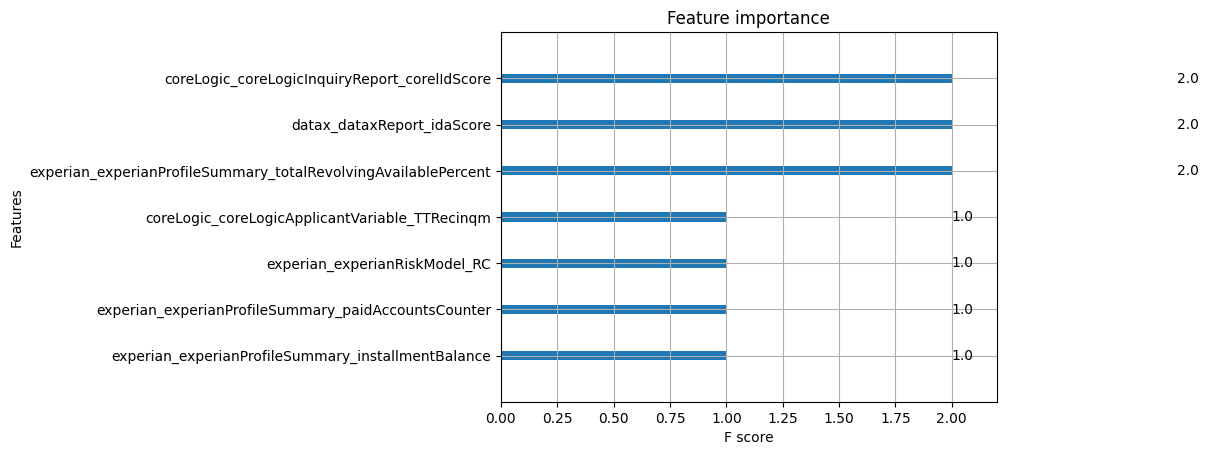

In [18]:
xgb.plot_importance(model, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

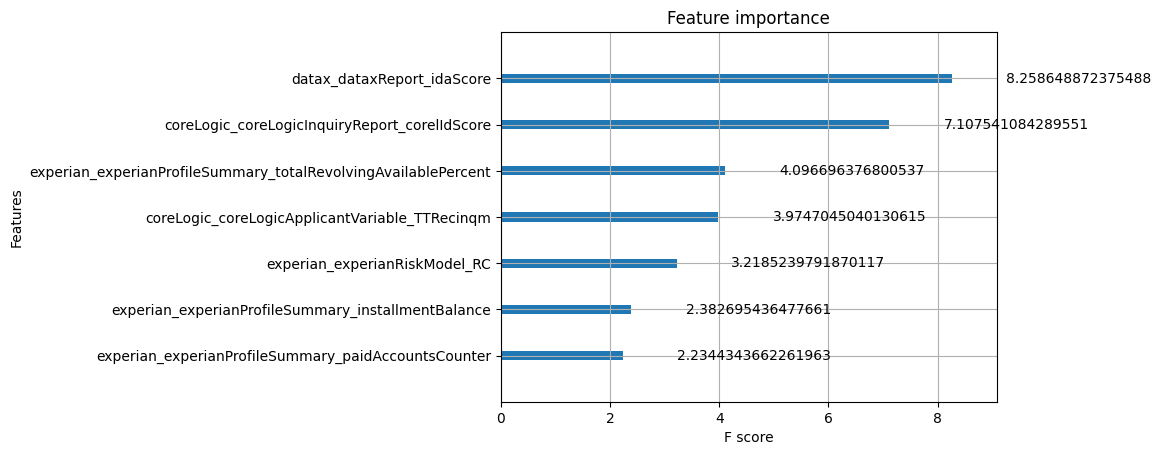

In [23]:
xgb.plot_importance(model, importance_type='gain')

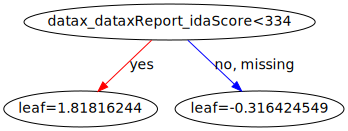

In [24]:
xgb.to_graphviz(model, num_trees=0)

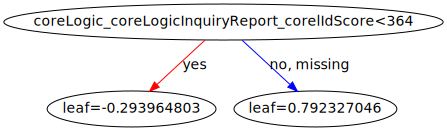

In [25]:
xgb.to_graphviz(model, num_trees=1)


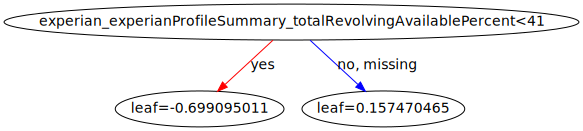

In [26]:
xgb.to_graphviz(model, num_trees=2)


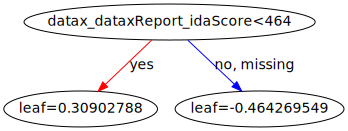

In [49]:
xgb.to_graphviz(model, num_trees=3)


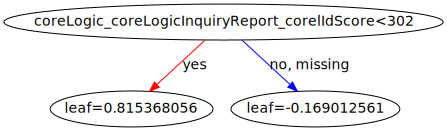

In [50]:
xgb.to_graphviz(model, num_trees=4)


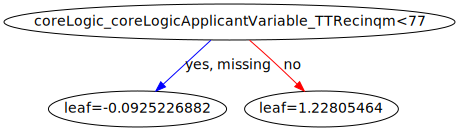

In [51]:
xgb.to_graphviz(model, num_trees=5)


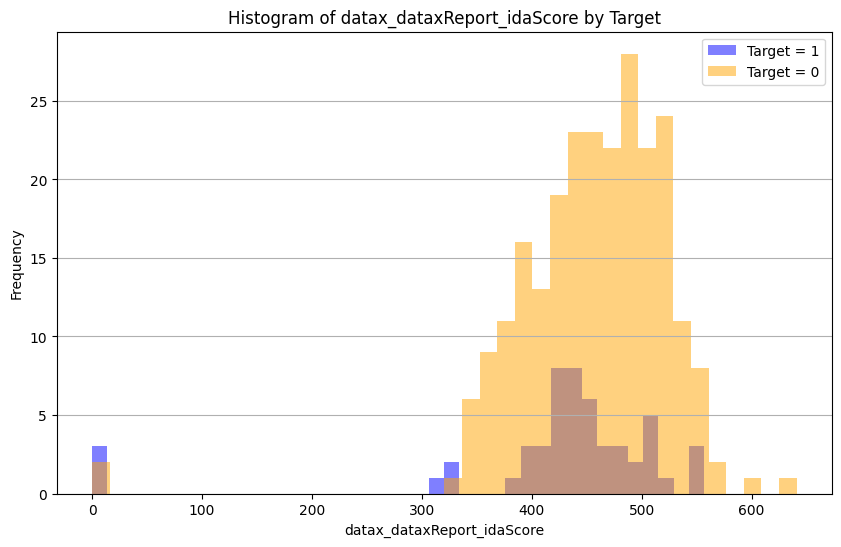

In [38]:
import matplotlib.pyplot as plt

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['datax_dataxReport_idaScore']
data_target_0 = df_filtered[df_filtered['target'] == 0]['datax_dataxReport_idaScore']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of datax_dataxReport_idaScore by Target')
plt.xlabel('datax_dataxReport_idaScore')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

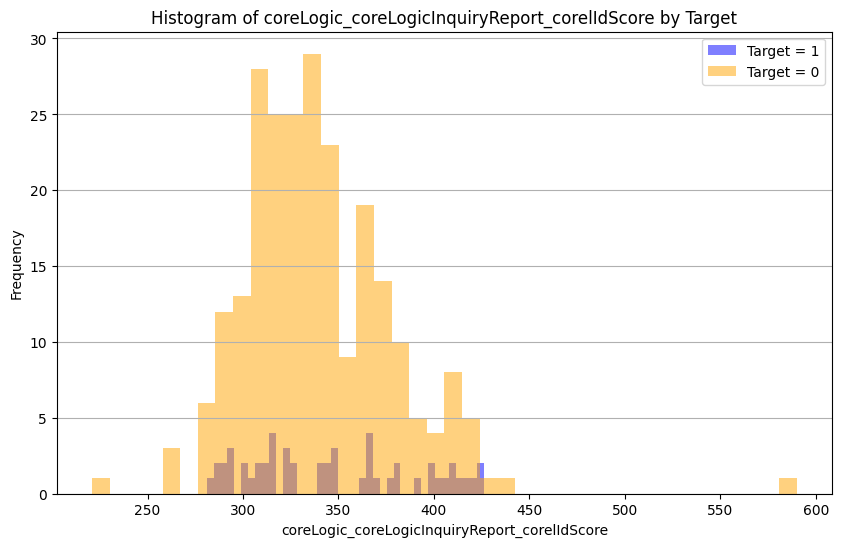

In [39]:
import matplotlib.pyplot as plt

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['coreLogic_coreLogicInquiryReport_corelIdScore']
data_target_0 = df_filtered[df_filtered['target'] == 0]['coreLogic_coreLogicInquiryReport_corelIdScore']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of coreLogic_coreLogicInquiryReport_corelIdScore by Target')
plt.xlabel('coreLogic_coreLogicInquiryReport_corelIdScore')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

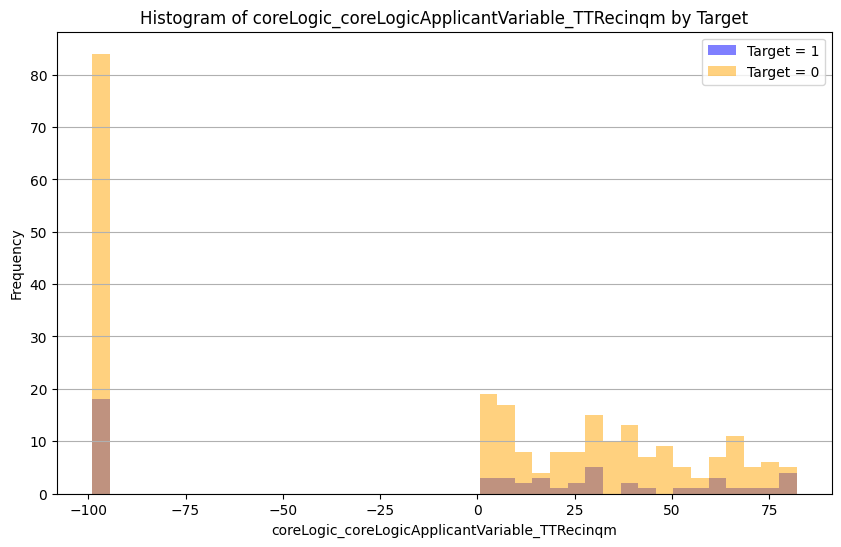

In [28]:
import matplotlib.pyplot as plt

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['coreLogic_coreLogicApplicantVariable_TTRecinqm']
data_target_0 = df_filtered[df_filtered['target'] == 0]['coreLogic_coreLogicApplicantVariable_TTRecinqm']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of coreLogic_coreLogicApplicantVariable_TTRecinqm by Target')
plt.xlabel('coreLogic_coreLogicApplicantVariable_TTRecinqm')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

In [27]:
df_filtered.columns

Index(['experian_experianProfileSummary_installmentBalance',
       'experian_experianProfileSummary_totalRevolvingBalance',
       'experian_experianProfileSummary_totalRevolvingAvailablePercent',
       'experian_experianProfileSummary_pastDueAmount',
       'experian_experianProfileSummary_monthlyPayment',
       'experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter',
       'experian_experianProfileSummary_totalInquiriesCounter',
       'experian_experianProfileSummary_totalTradeItemsCounter',
       'experian_experianProfileSummary_paidAccountsCounter',
       'experian_experianProfileSummary_wasDelinquentDerogCounter',
       'experian_experianProfileSummary_thirtyDayCounter',
       'experian_experianProfileSummary_ninetyPlusDayCounter',
       'experian_experianProfileSummary_derogCounter',
       'experian_experianRiskModel_V3', 'experian_experianRiskModel_RC',
       'datax_dataxReport_idaScore',
       'coreLogic_coreLogicInquiryReport_corelIdScore',
       'c

## Model 8

In [11]:
# Train xgb model 

# for model 
# Only look at model 13 grade A's 
df_filtered = df[df['m8_grade']=='A']

# Target 1 if from dark score period and 0 if from  prod 
df_filtered['target'] = (df_filtered['CREATED_TS'] <= '2024-12-10').astype(int)

df_filtered = df_filtered.drop(['CREATED_TS', 'M13_SCORE', 'M8_SCORE', 'm13_grade', 'm8_grade',], axis=1)

X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

dtrain = xgb.DMatrix(X, label=y, missing=-99)

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',   
    'max_leaves': 2,
    'grow_policy': 'lossguide',        
    'eta': 1,                     
    'subsample': 1,              
    'colsample_bytree': 1,        
    'seed': 42                      
}

num_round = 10

model = xgb.train(params, dtrain, num_boost_round=num_round)

y_pred = model.predict(dtrain)

print(roc_auc_score(y, y_pred))

# df_filtered['target'].value_counts()




0.795341474445952


/tmp/ipykernel_3480013/688167538.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['target'] = (df_filtered['CREATED_TS'] <= '2024-12-10').astype(int)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

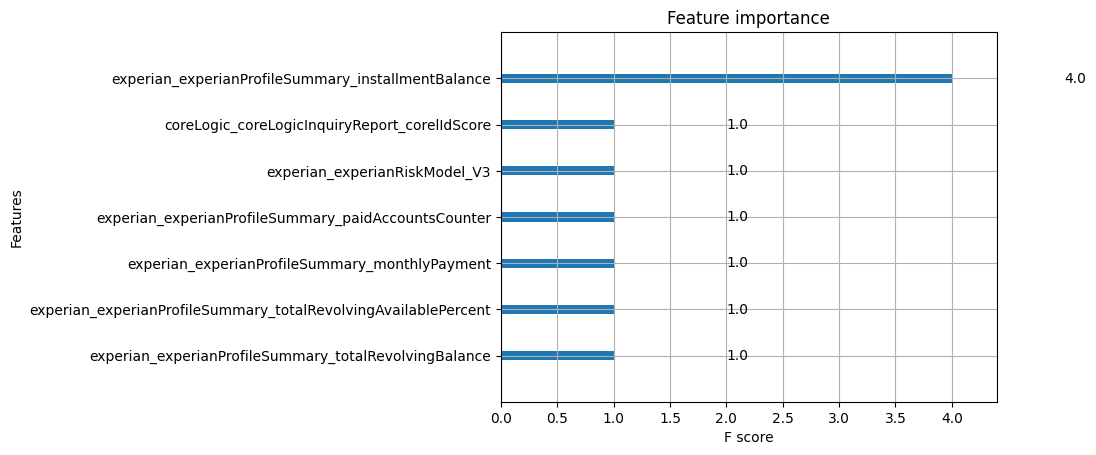

In [12]:
xgb.plot_importance(model, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

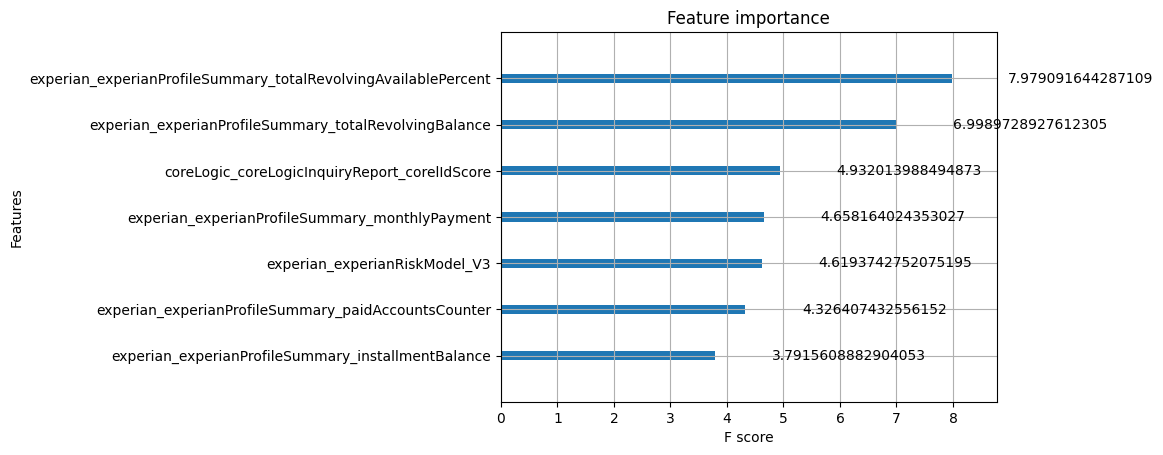

In [13]:
xgb.plot_importance(model, importance_type='gain')


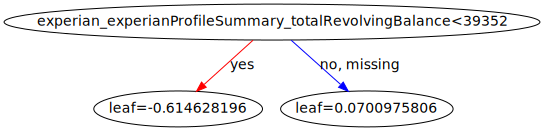

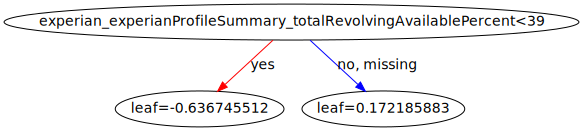

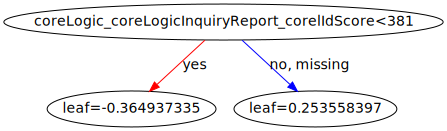

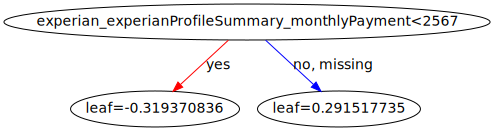

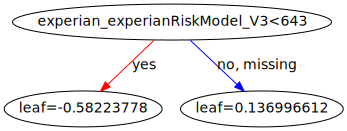

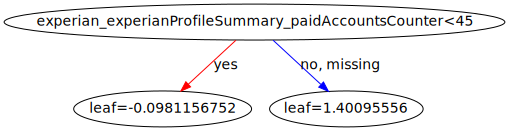

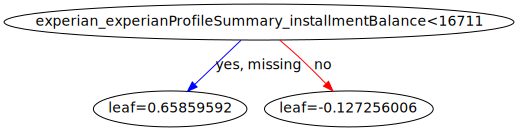

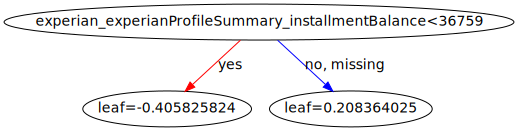

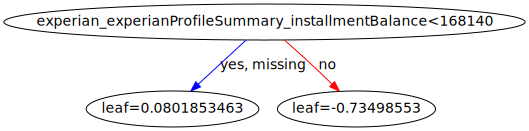

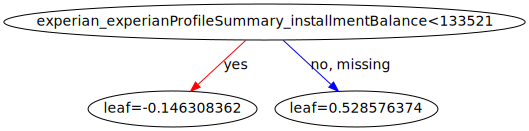

In [20]:
for i in range(10):
    display(xgb.to_graphviz(model, num_trees=i))
    


In [46]:
df_filtered.columns

Index(['experian_experianProfileSummary_installmentBalance',
       'experian_experianProfileSummary_totalRevolvingBalance',
       'experian_experianProfileSummary_totalRevolvingAvailablePercent',
       'experian_experianProfileSummary_pastDueAmount',
       'experian_experianProfileSummary_monthlyPayment',
       'experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter',
       'experian_experianProfileSummary_totalInquiriesCounter',
       'experian_experianProfileSummary_totalTradeItemsCounter',
       'experian_experianProfileSummary_paidAccountsCounter',
       'experian_experianProfileSummary_wasDelinquentDerogCounter',
       'experian_experianProfileSummary_thirtyDayCounter',
       'experian_experianProfileSummary_ninetyPlusDayCounter',
       'experian_experianProfileSummary_derogCounter',
       'experian_experianRiskModel_V3', 'experian_experianRiskModel_RC',
       'datax_dataxReport_idaScore',
       'coreLogic_coreLogicInquiryReport_corelIdScore',
       'c

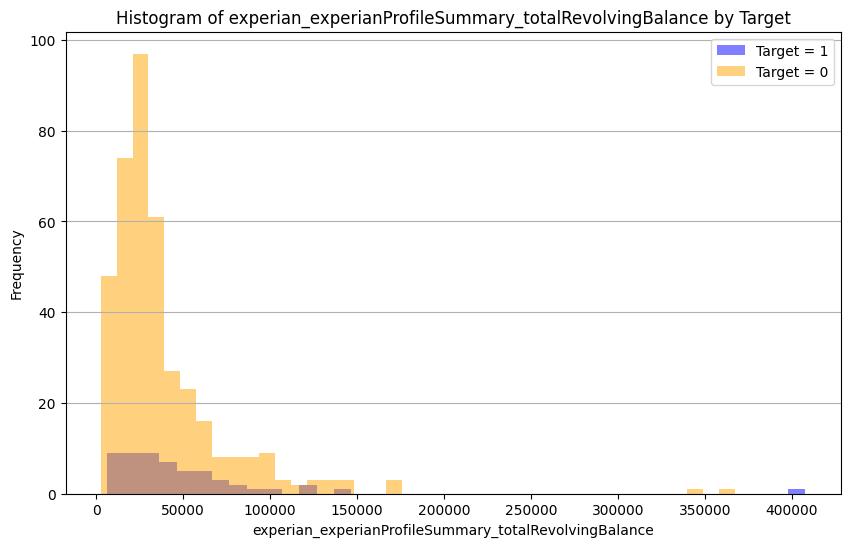

In [47]:
import matplotlib.pyplot as plt

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['experian_experianProfileSummary_totalRevolvingBalance']
data_target_0 = df_filtered[df_filtered['target'] == 0]['experian_experianProfileSummary_totalRevolvingBalance']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of experian_experianProfileSummary_totalRevolvingBalance by Target')
plt.xlabel('experian_experianProfileSummary_totalRevolvingBalance')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

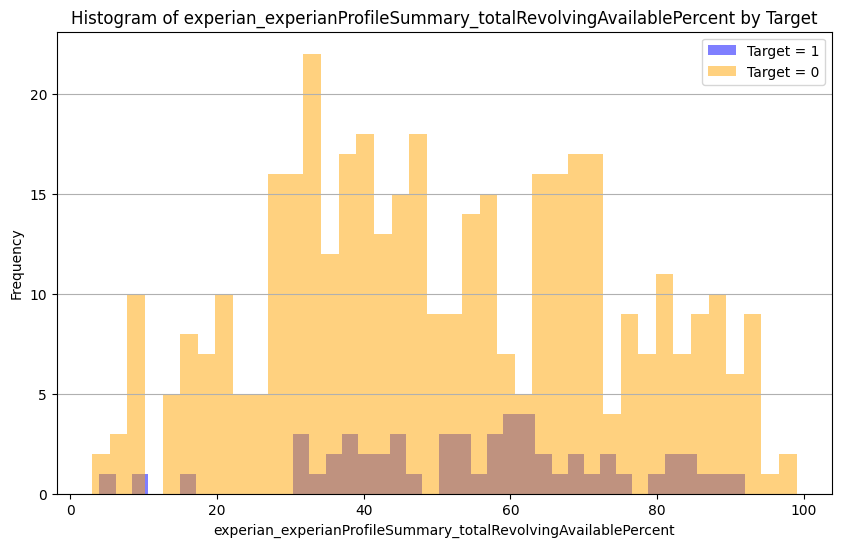

In [21]:

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['experian_experianProfileSummary_totalRevolvingAvailablePercent']
data_target_0 = df_filtered[df_filtered['target'] == 0]['experian_experianProfileSummary_totalRevolvingAvailablePercent']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of experian_experianProfileSummary_totalRevolvingAvailablePercent by Target')
plt.xlabel('experian_experianProfileSummary_totalRevolvingAvailablePercent')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

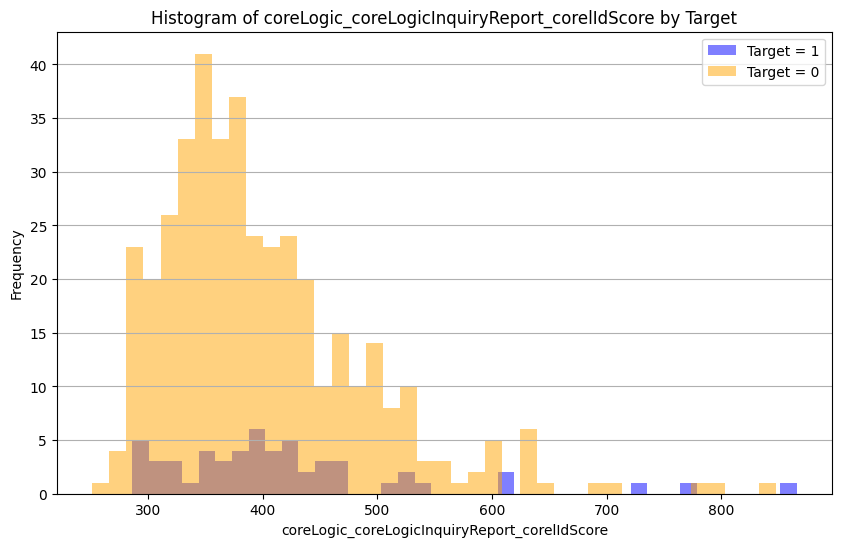

In [22]:

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['coreLogic_coreLogicInquiryReport_corelIdScore']
data_target_0 = df_filtered[df_filtered['target'] == 0]['coreLogic_coreLogicInquiryReport_corelIdScore']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of coreLogic_coreLogicInquiryReport_corelIdScore by Target')
plt.xlabel('coreLogic_coreLogicInquiryReport_corelIdScore')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

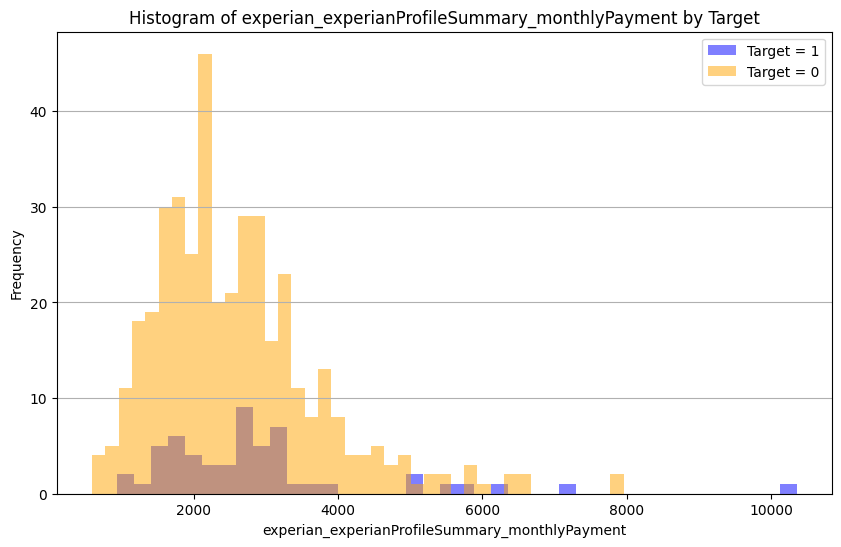

In [24]:

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['experian_experianProfileSummary_monthlyPayment']
data_target_0 = df_filtered[df_filtered['target'] == 0]['experian_experianProfileSummary_monthlyPayment']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of experian_experianProfileSummary_monthlyPayment by Target')
plt.xlabel('experian_experianProfileSummary_monthlyPayment')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

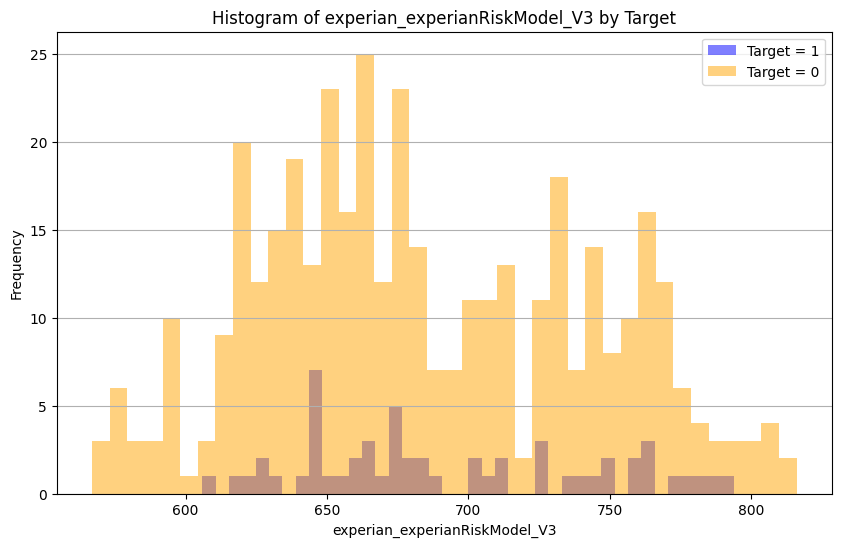

In [25]:

# Filter the data based on the target column
data_target_1 = df_filtered[df_filtered['target'] == 1]['experian_experianRiskModel_V3']
data_target_0 = df_filtered[df_filtered['target'] == 0]['experian_experianRiskModel_V3']

# Plot histograms for both subsets
plt.figure(figsize=(10, 6))
plt.hist(data_target_1, bins=40, alpha=0.5, label='Target = 1', color='blue')
plt.hist(data_target_0, bins=40, alpha=0.5, label='Target = 0', color='orange')

# Add titles and labels
plt.title('Histogram of experian_experianRiskModel_V3 by Target')
plt.xlabel('experian_experianRiskModel_V3')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
df['coreLogic_coreLogicApplicantVariable_TTRecinqm'].value_counts(dropna = True)

In [ ]:
df['coreLogic_coreLogicApplicantVariable_TTRecinqm'].value_counts(dropna = True, normalize = True)

In [ ]:
df_train['coreLogic_coreLogicApplicantVariable_TTRecinqm'].value_counts(dropna = True, normalize = True)

In [ ]:
df['coreLogic_coreLogicApplicantVariable_TTRecinqm'].hist()

In [ ]:
df_train['coreLogic_coreLogicApplicantVariable_TTRecinqm'].hist()

In [ ]:
df['experian_experianProfileSummary_totalInquiriesCounter'].hist()

In [ ]:
df_train['experian_experianProfileSummary_totalInquiriesCounter'].hist()

In [ ]:
# for i in range(10):
#   fig, ax = plt.subplots(figsize=(90, 90))
#   xgb.plot_tree(model, num_trees=i, ax=ax)
#   plt.show()

np.float64(0.8142482517482518)